# In this notebook, we'll perform the following analyses:

### 1. High-Performing Campaign Analysis:
- Identify top 10% of campaigns by ROAS
- Analyze common characteristics (ad platform, campaign type, targeting)

### 2. Detailed Time Series Analysis:
- Decompose time series for Spend, Conversions, and Revenue into trend, seasonality, and residual components
- Identify any weekly or monthly patterns

### 3. Platform Performance Comparison:
- Conduct statistical tests (e.g., ANOVA) to compare performance metrics across platforms
- Visualize performance distribution for each platform

### 4. Efficiency Metric Deep Dive:
- Analyze the distribution and trends of CTR, CVR, and ROAS over time
- Identify campaigns with consistently high efficiency metrics

### 5. Budget Allocation Analysis:
- Compare current budget allocation across platforms with their performance
- Suggest optimal budget allocation based on historical performance

### 6. Correlation Analysis:
- Perform a more detailed correlation analysis, including lagged correlations
- Identify leading indicators of performance

### 7. Conversion Path Analysis:
- Analyze the typical conversion path across different ad platforms
- Identify which platforms are most effective at different stages of the customer journey

### 8. Anomaly Detection:
- Implement simple anomaly detection to identify outlier days or campaigns
- Investigate reasons behind these anomalies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from sklearn.ensemble import IsolationForest
import statsmodels.api as sm

In [2]:
data = pd.read_csv('../data/processed/combined_ad_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [3]:
import os

# Create directories if they don't exist
os.makedirs("../plots/02_in_depth_analysis", exist_ok=True)

In [4]:

# 1. High-Performing Campaign Analysis
def analyze_top_campaigns(data, metric='ROAS', top_percent=0.1):
    top_campaigns = data.nlargest(int(len(data) * top_percent), metric)
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Source', data=top_campaigns)
    plt.title(f'Distribution of Top {top_percent*100}% Campaigns by {metric}')
    plt.savefig(f"../plots/02_in_depth_analysis/top_campaigns_{metric}.png")
    plt.show()
    
    print(top_campaigns.groupby('Source')[metric].describe())
    
    return top_campaigns

# 2. Detailed Time Series Analysis
def time_series_decomposition(data, column):
    daily_data = data.groupby('Date')[column].sum().reset_index()
    daily_data.set_index('Date', inplace=True)
    
    decomposition = seasonal_decompose(daily_data, model='additive', period=7)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(411)
    plt.plot(daily_data, label='Observed')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f"../plots/02_in_depth_analysis/time_series_decomposition_{column}.png")
    plt.show()

# 3. Platform Performance Comparison
def compare_platforms(data):
    metrics = ['Impressions', 'Clicks', 'Spend', 'Conversions', 'Revenue', 'CTR', 'CPC', 'CVR', 'ROAS']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Source', y=metric, data=data)
        plt.title(f'{metric} by Platform')
        plt.savefig(f"../plots/02_in_depth_analysis/platform_comparison_{metric}.png")
        plt.show()
        
        # Perform one-way ANOVA
        groups = [group for _, group in data.groupby('Source')[metric]]
        f_value, p_value = stats.f_oneway(*groups)
        print(f'ANOVA test for {metric}: F-value: {f_value}, p-value: {p_value}')

# 4. Efficiency Metric Deep Dive
def analyze_efficiency_metrics(data):
    efficiency_metrics = ['CTR', 'CVR', 'ROAS']
    
    for metric in efficiency_metrics:
        plt.figure(figsize=(15, 5))
        data.groupby('Date')[metric].mean().plot()
        plt.title(f'Average {metric} Over Time')
        plt.savefig(f"../plots/02_in_depth_analysis/efficiency_metric_{metric}.png")
        plt.show()
        
    # Identify campaigns with consistently high efficiency
    high_efficiency = data.groupby('Campaign type').agg({
        'CTR': 'mean',
        'CVR': 'mean',
        'ROAS': 'mean'
    }).sort_values('ROAS', ascending=False)
    
    print("Top 10 campaigns by efficiency:")
    print(high_efficiency.head(10))

# 5. Budget Allocation Analysis
def analyze_budget_allocation(data):
    current_allocation = data.groupby('Source')['Spend'].sum()
    current_performance = data.groupby('Source')['Revenue'].sum()
    
    plt.figure(figsize=(10, 6))
    current_allocation.plot(kind='pie', autopct='%1.1f%%', title='Current Budget Allocation')
    plt.savefig("../plots/02_in_depth_analysis/current_budget_allocation.png")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    current_performance.plot(kind='pie', autopct='%1.1f%%', title='Revenue Distribution')
    plt.savefig("../plots/02_in_depth_analysis/revenue_distribution.png")
    plt.show()
    
    roas_by_source = current_performance / current_allocation
    print("ROAS by Source:")
    print(roas_by_source)
    
    # Simple optimization suggestion
    total_budget = current_allocation.sum()
    suggested_allocation = (roas_by_source / roas_by_source.sum()) * total_budget
    
    print("\nSuggested Budget Allocation:")
    print(suggested_allocation)

# 6. Correlation Analysis
def detailed_correlation_analysis(data):
    metrics = ['Impressions', 'Clicks', 'Spend', 'Conversions', 'Revenue', 'CTR', 'CPC', 'CVR', 'ROAS']
    correlation_matrix = data[metrics].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Key Metrics')
    plt.savefig("../plots/02_in_depth_analysis/correlation_heatmap.png")
    plt.show()
    
    # Lagged correlations
    for metric in ['Spend', 'Clicks']:
        for lag in [1, 7, 30]:
            data[f'{metric}_lag_{lag}'] = data.groupby('Source')[metric].shift(lag)
    
    lagged_correlation = data[['Revenue'] + [col for col in data.columns if 'lag' in col]].corr()['Revenue'].sort_values(ascending=False)
    print("Top lagged correlations with Revenue:")
    print(lagged_correlation)

# 7. Conversion Path Analysis
def analyze_conversion_path(data):
    # This analysis requires user-level data which isn't available in the current dataset
    # Here's a placeholder for what could be done with such data
    print("Conversion Path Analysis requires user-level data.")
    print("With such data, we could:")
    print("1. Identify the most common sequences of ad interactions before conversion")
    print("2. Calculate the average number of touchpoints before conversion")
    print("3. Determine which platforms are most effective at different stages of the customer journey")

# 8. Anomaly Detection
def detect_anomalies(data):
    # Using Isolation Forest for anomaly detection
    clf = IsolationForest(contamination=0.1, random_state=42)
    data['anomaly'] = clf.fit_predict(data[['Spend', 'Conversions', 'Revenue']])
    
    anomalies = data[data['anomaly'] == -1]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Spend'], data['Revenue'], c=data['anomaly'], cmap='viridis')
    plt.colorbar()
    plt.xlabel('Spend')
    plt.ylabel('Revenue')
    plt.title('Anomaly Detection in Spend vs Revenue')
    plt.savefig("../plots/02_in_depth_analysis/anomaly_detection.png")
    plt.show()
    
    print("Top 10 anomalous days:")
    print(anomalies.sort_values('Spend', ascending=False)[['Date', 'Source', 'Spend', 'Revenue']].head(10))


1. High-Performing Campaign Analysis


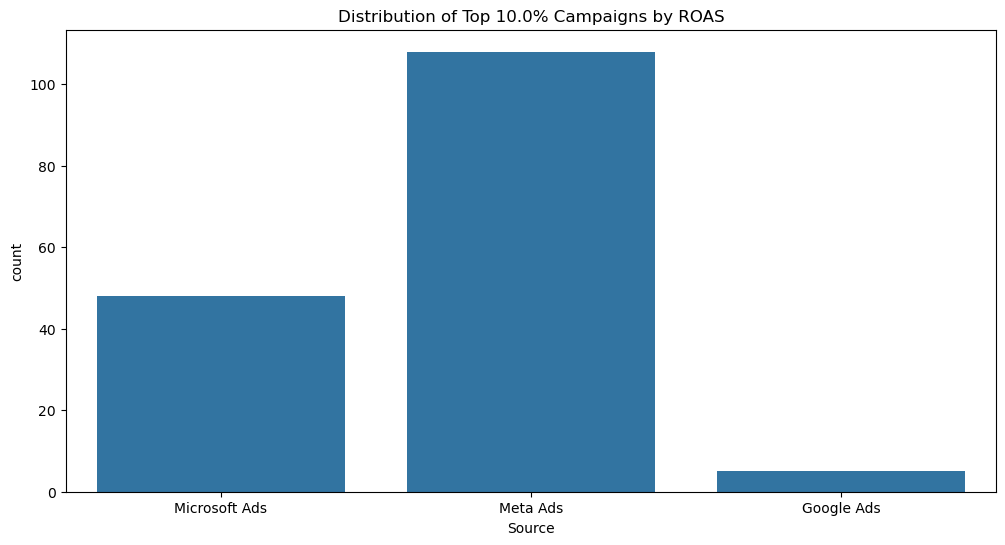

               count       mean         std        min        25%        50%  \
Source                                                                         
Google Ads       5.0  14.151752    4.464528  11.025860  12.010340  12.768911   
Meta Ads       108.0  46.503825   35.382867  10.687500  23.924983  37.838490   
Microsoft Ads   48.0  72.547964  277.208517  10.655091  12.385154  16.179158   

                     75%          max  
Source                                 
Google Ads     12.930026    22.023622  
Meta Ads       57.053938   226.824228  
Microsoft Ads  25.073449  1932.000000  

2. Detailed Time Series Analysis

Time Series Decomposition for Spend


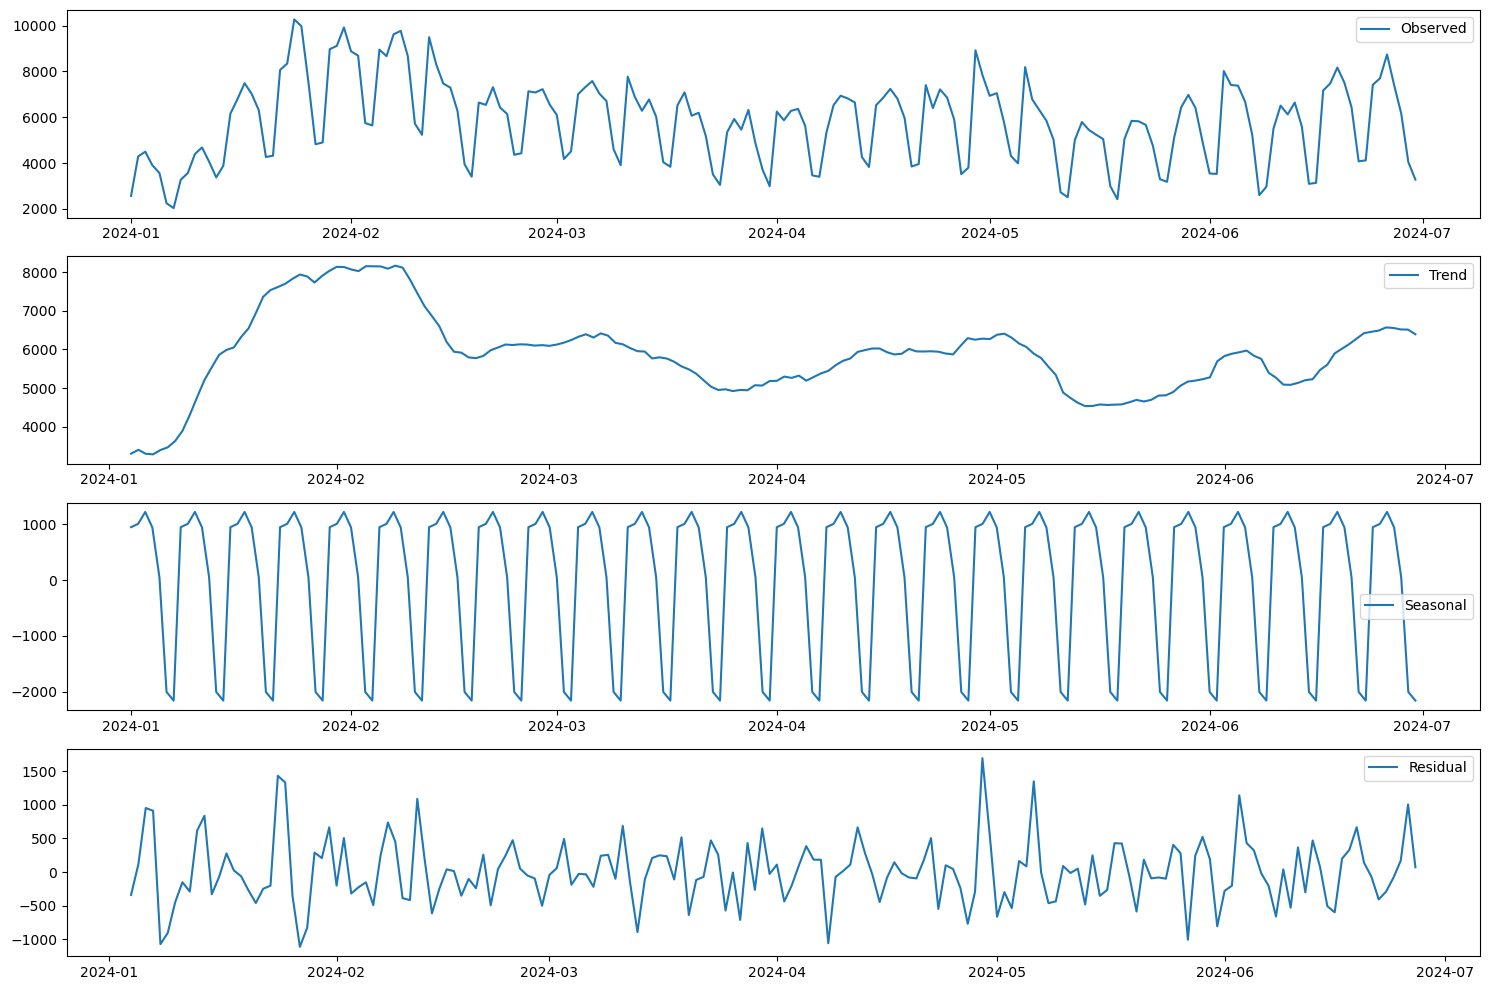


Time Series Decomposition for Conversions


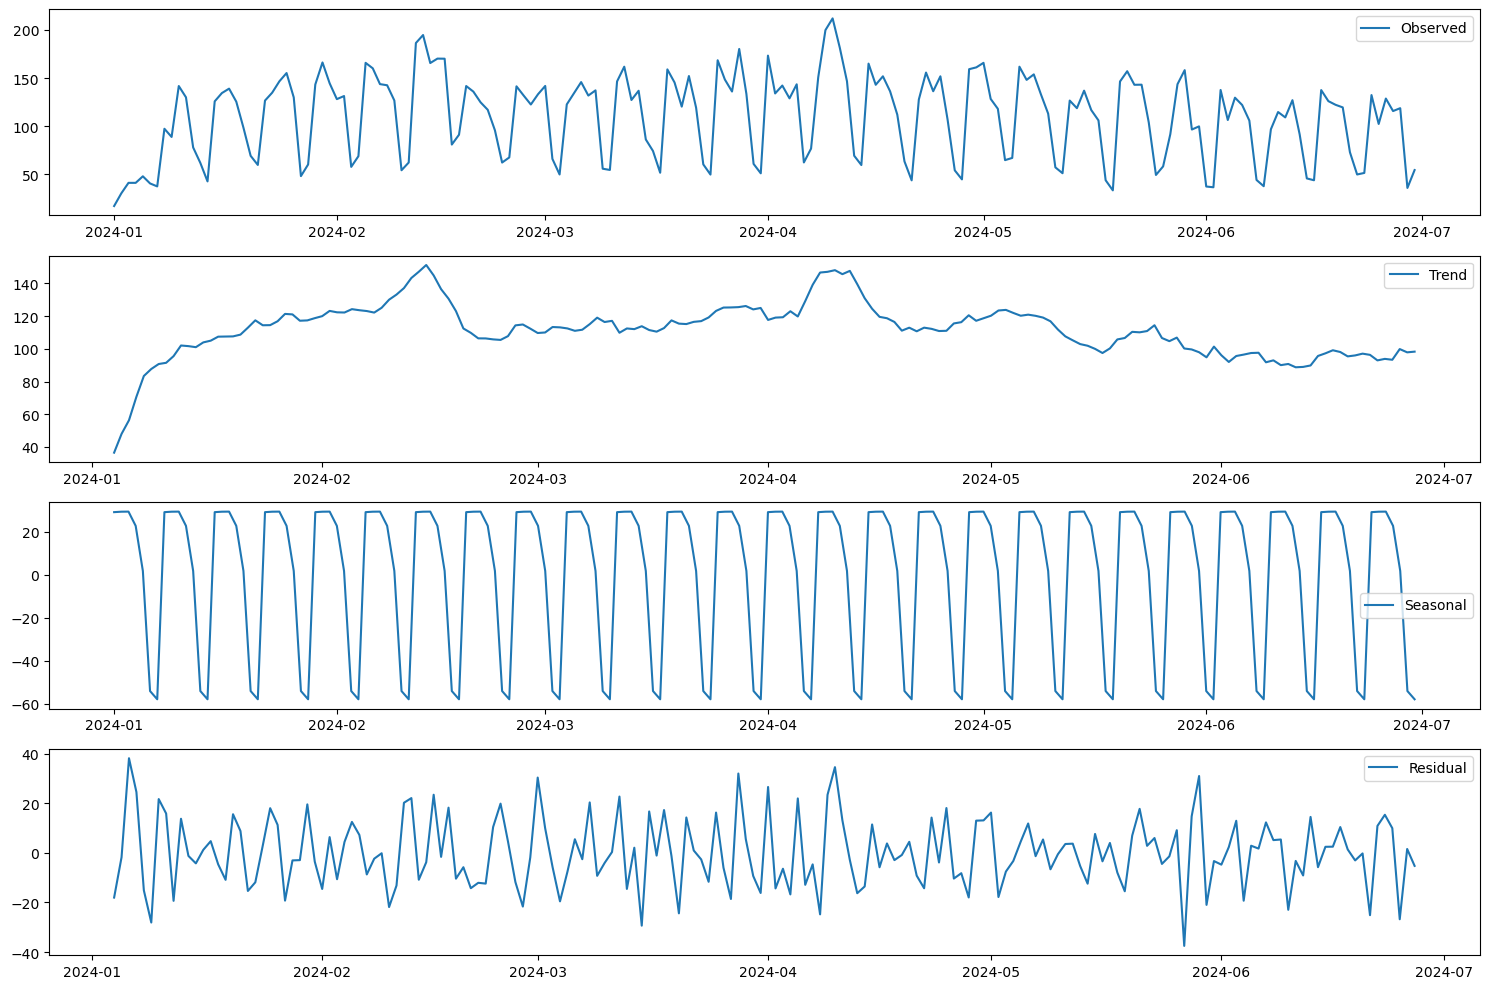


Time Series Decomposition for Revenue


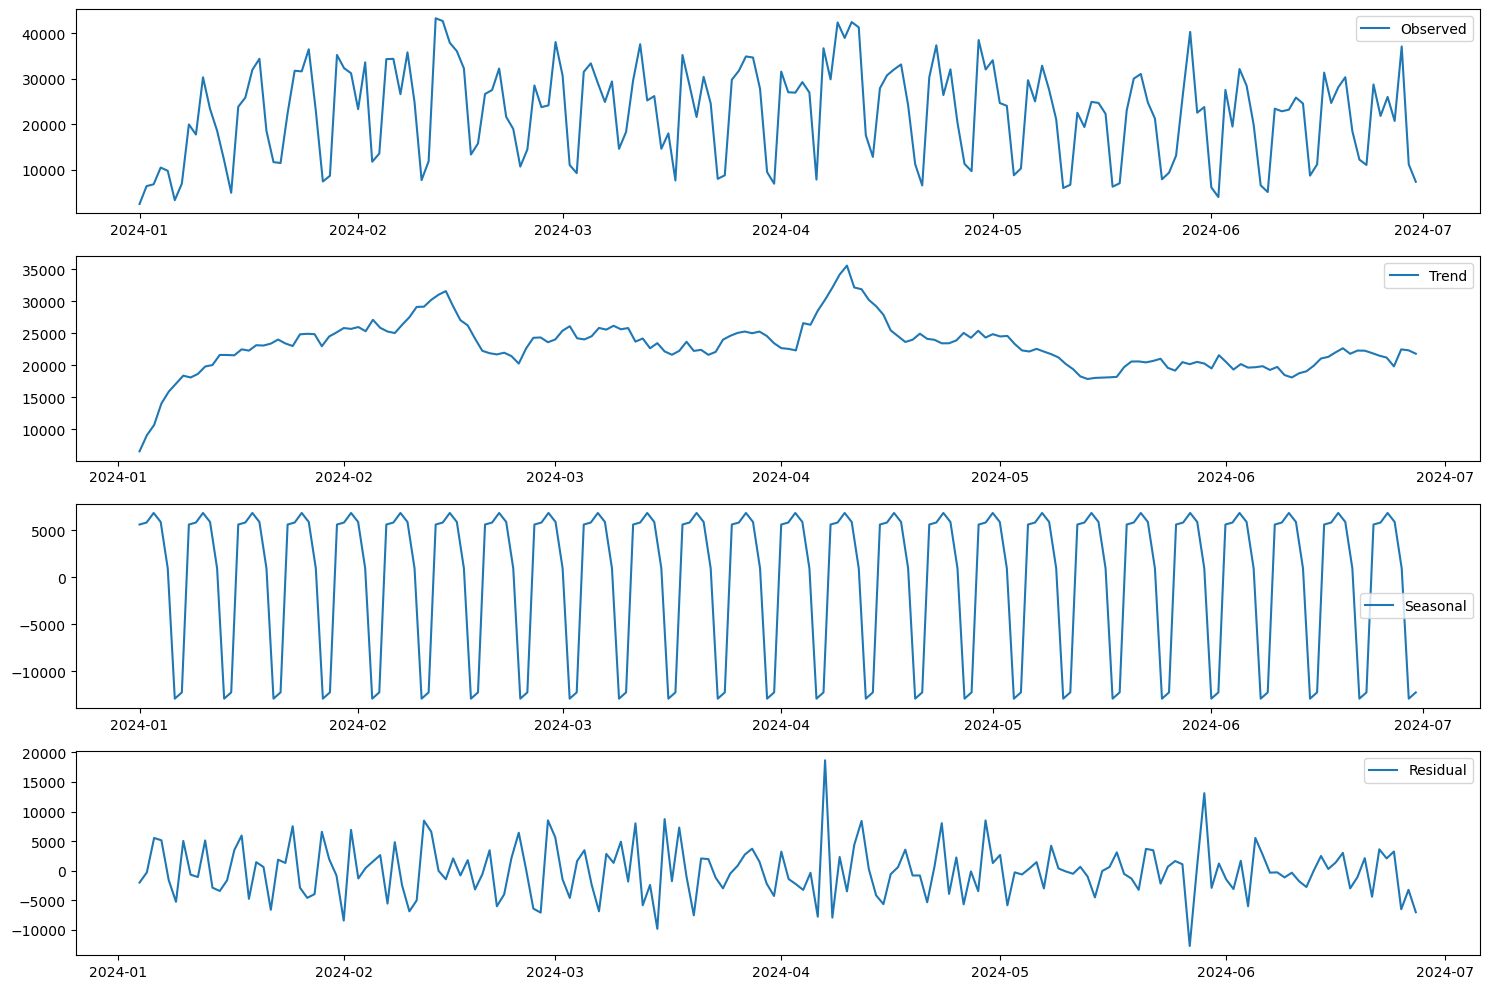


3. Platform Performance Comparison


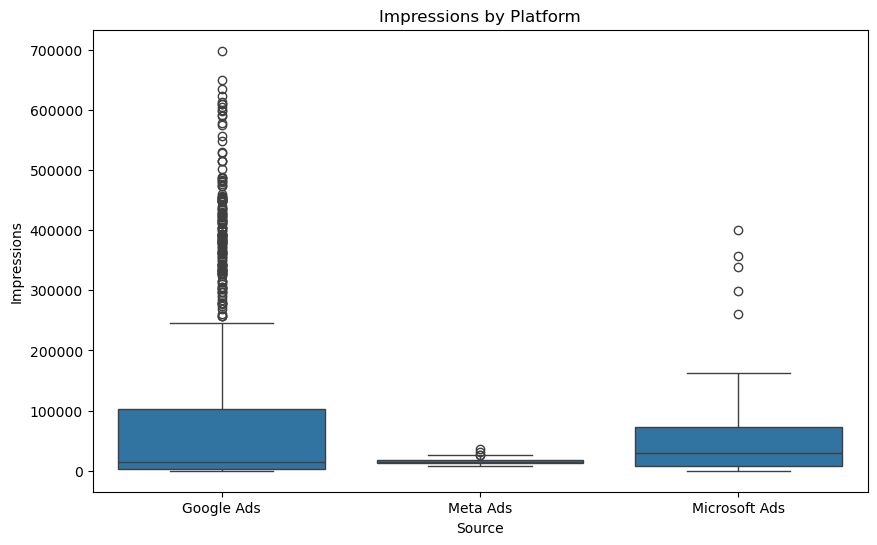

ANOVA test for Impressions: F-value: 63.062957879427316, p-value: 4.2613212151486596e-27


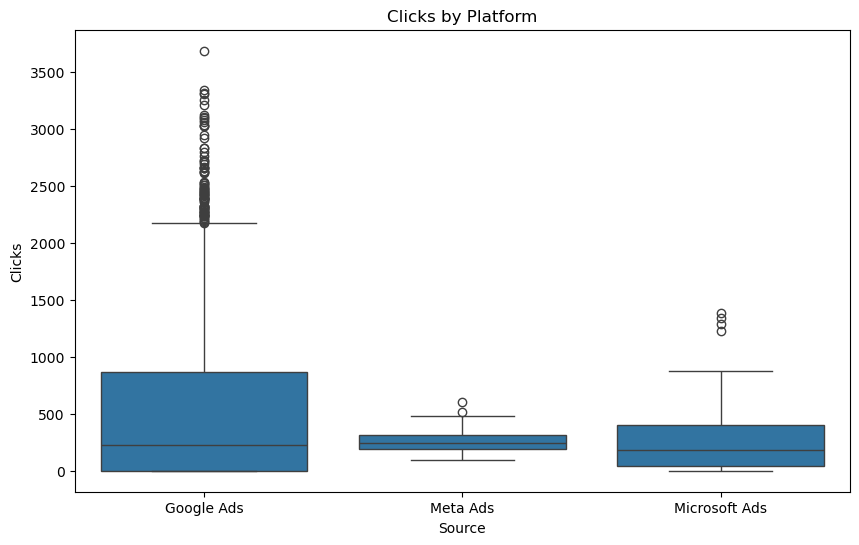

ANOVA test for Clicks: F-value: 94.30652327990175, p-value: 1.840023902359126e-39


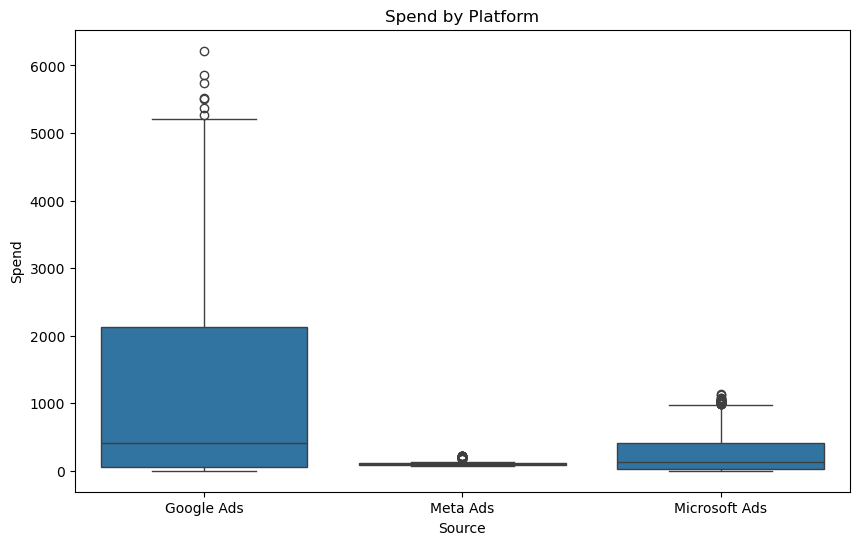

ANOVA test for Spend: F-value: 189.90219671107477, p-value: 8.596709732380743e-75


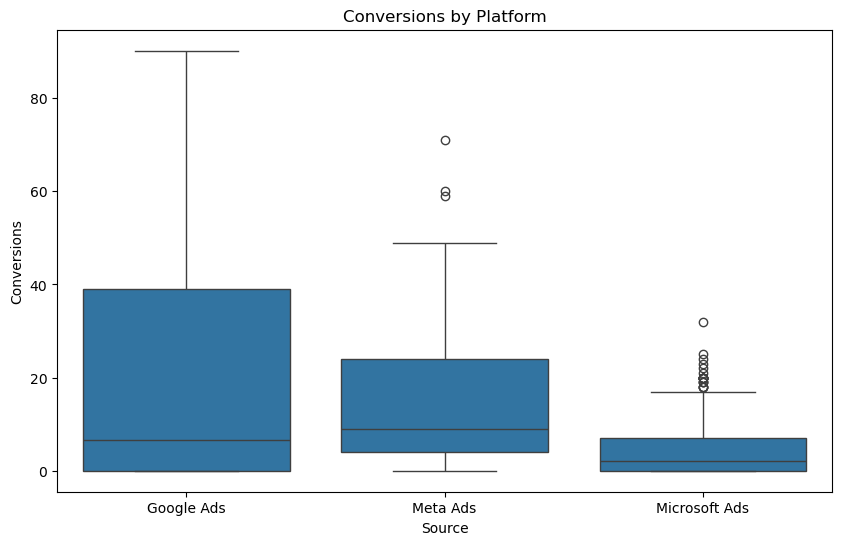

ANOVA test for Conversions: F-value: 153.00401554054355, p-value: 1.4209914739146025e-61


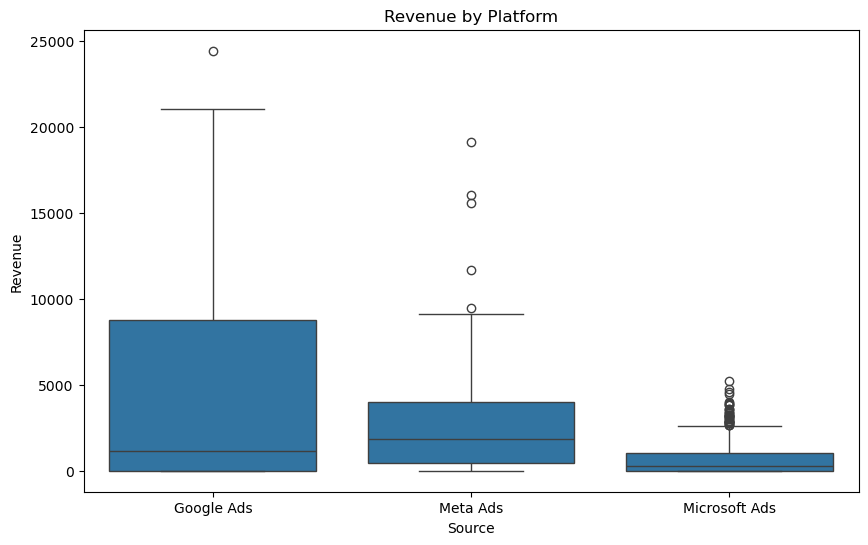

ANOVA test for Revenue: F-value: 167.68735665900059, p-value: 6.801726081097033e-67


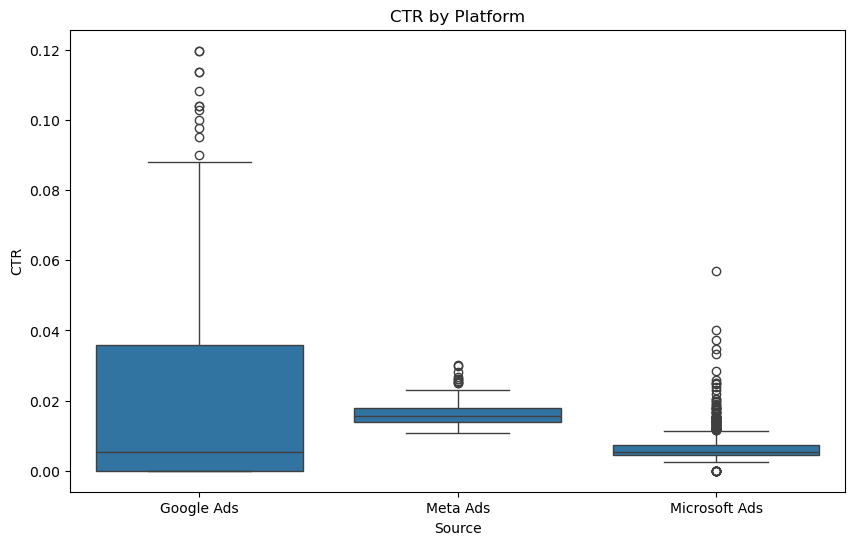

ANOVA test for CTR: F-value: 64.20975234573669, p-value: 1.4719762383887439e-27


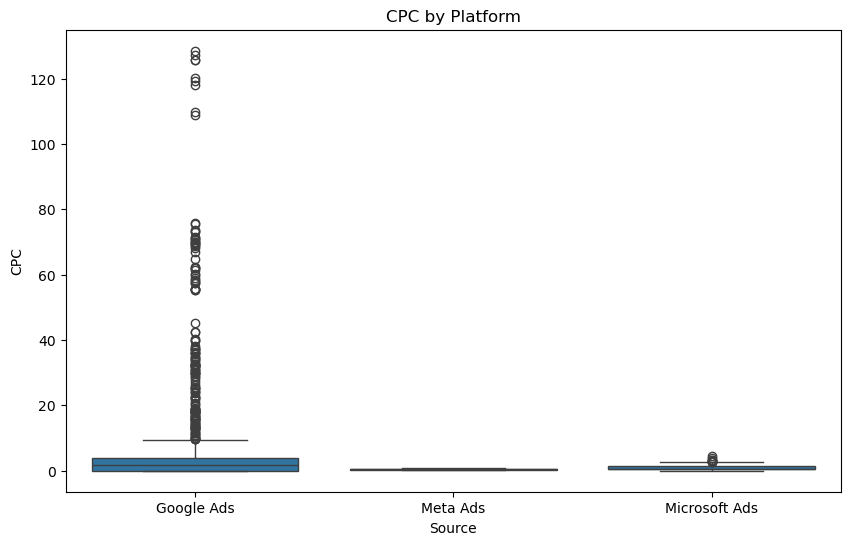

ANOVA test for CPC: F-value: 81.77132018340497, p-value: 1.4906881212575566e-34


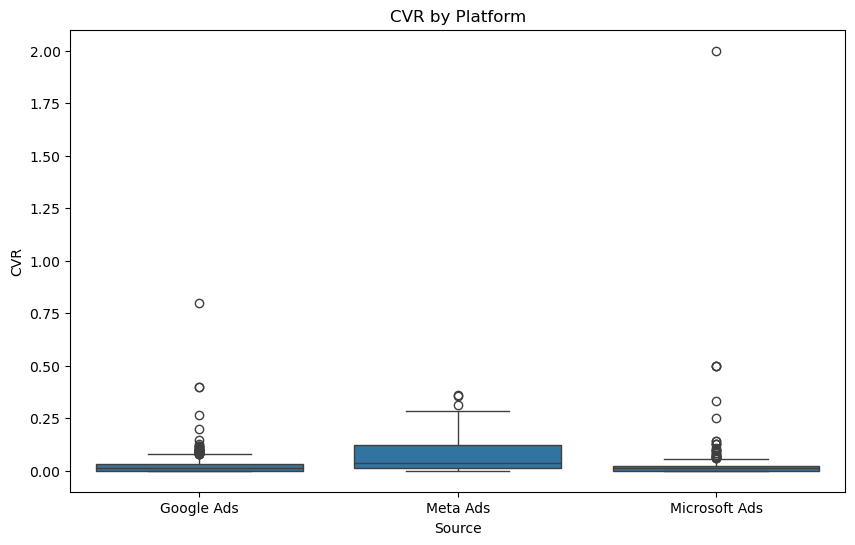

ANOVA test for CVR: F-value: 45.85480500846184, p-value: 4.2730336669804605e-20


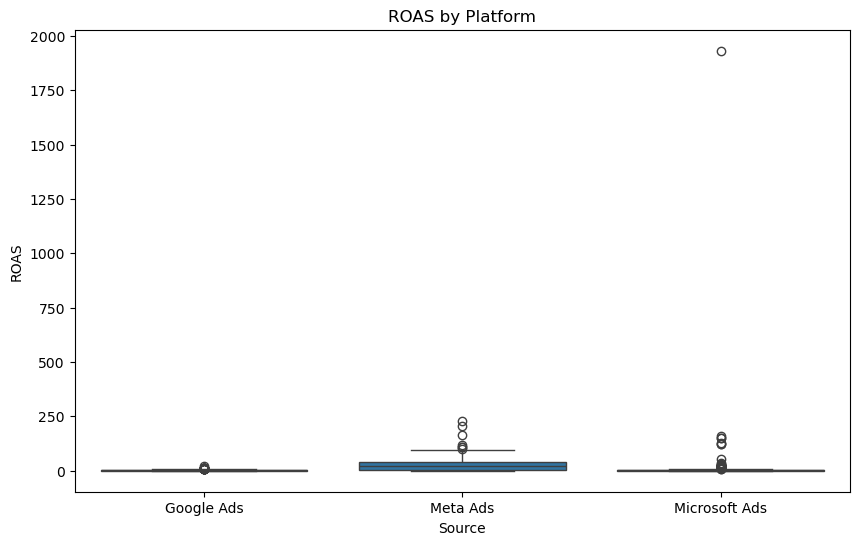

ANOVA test for ROAS: F-value: 20.70831454191146, p-value: 1.3180959935518608e-09

4. Efficiency Metric Deep Dive


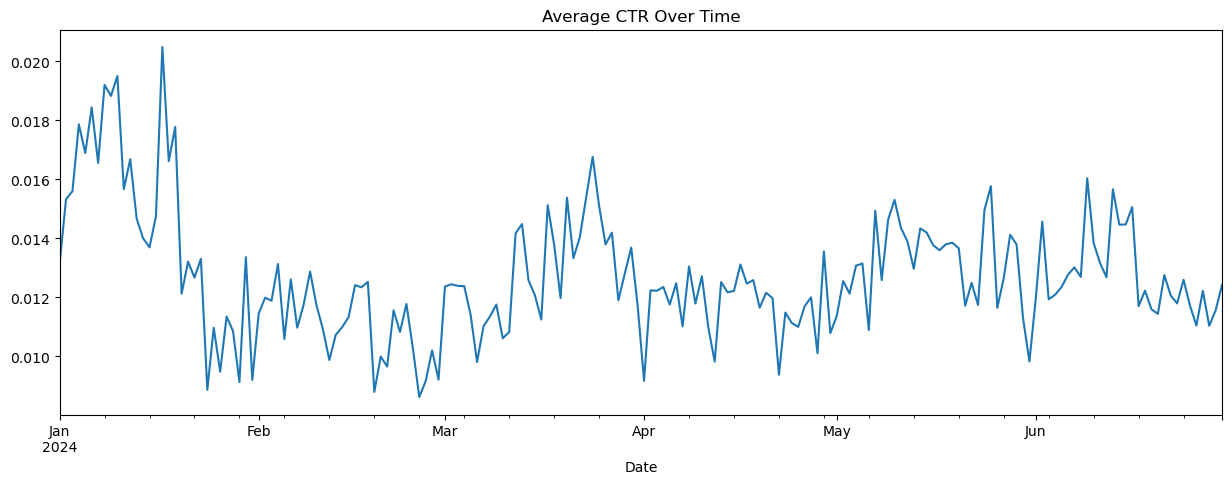

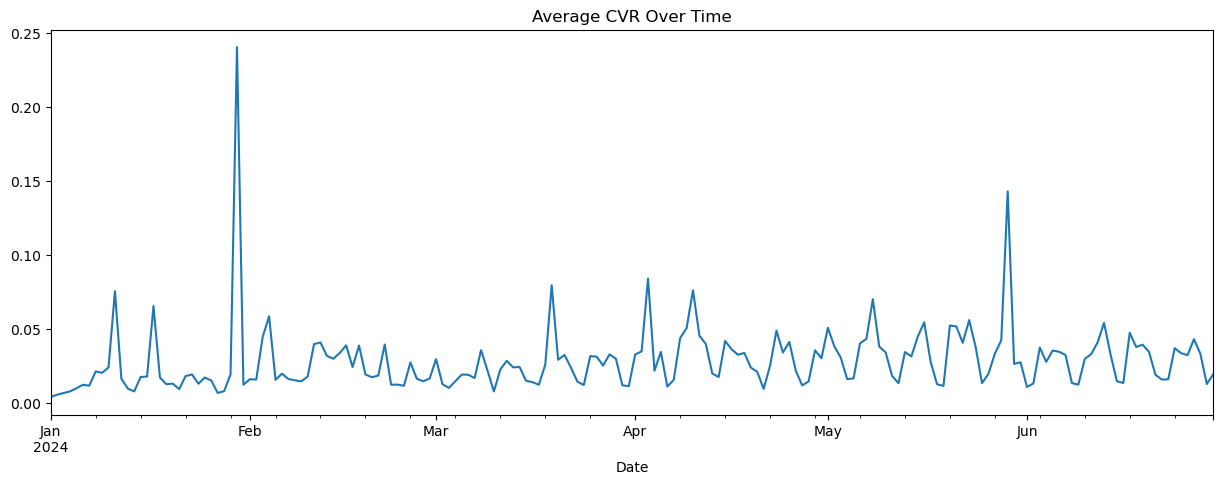

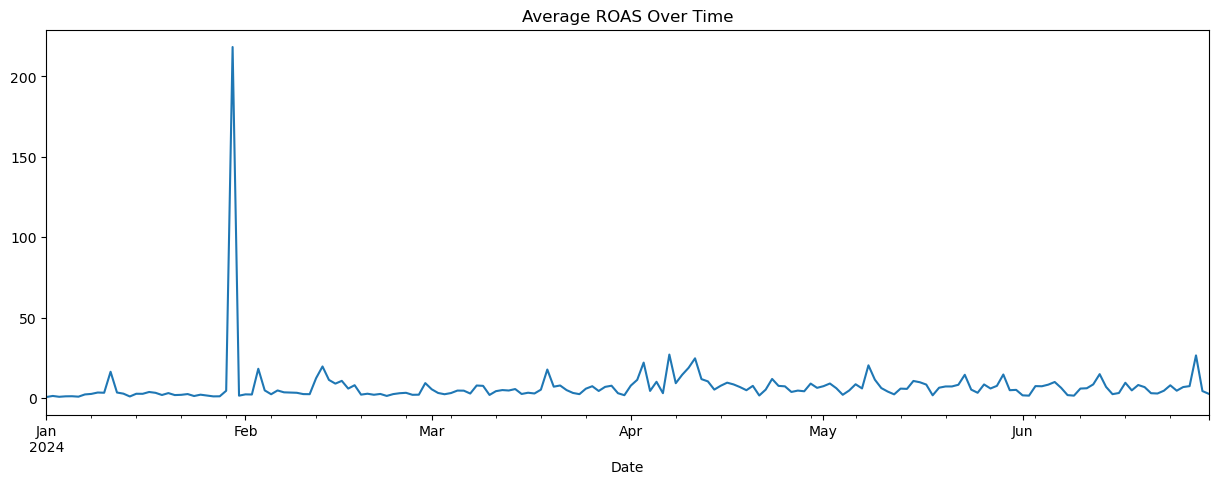

Top 10 campaigns by efficiency:
                       CTR       CVR       ROAS
Campaign type                                  
Performance max   0.011547  0.037077  16.931902
Cross-network     0.010993  0.048282  16.057153
Search Network    0.063084  0.061791   5.104951
Shopping          0.004750  0.020374   4.929186
Audience          0.005525  0.004738   3.205894
Search & content  0.005611  0.023449   2.322878
YouTube           0.000224  0.013477   0.235313
Display Network   0.000701  0.000000   0.000000

5. Budget Allocation Analysis


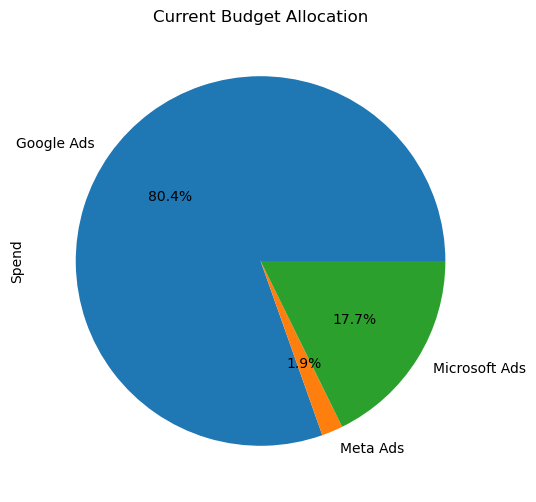

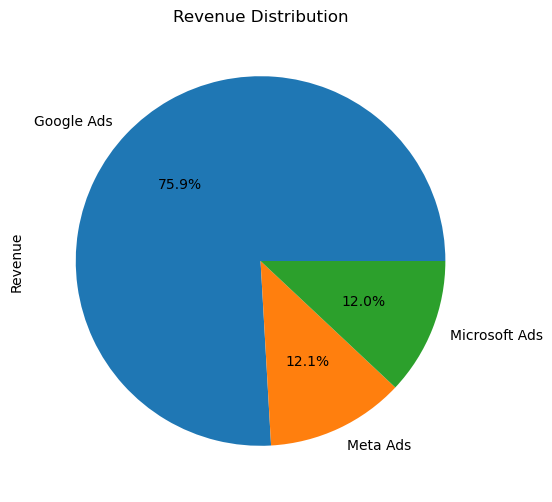

ROAS by Source:
Source
Google Ads        3.667424
Meta Ads         25.328298
Microsoft Ads     2.629981
dtype: float64

Suggested Budget Allocation:
Source
Google Ads       122967.988878
Meta Ads         849252.784105
Microsoft Ads     88182.727018
dtype: float64

6. Correlation Analysis


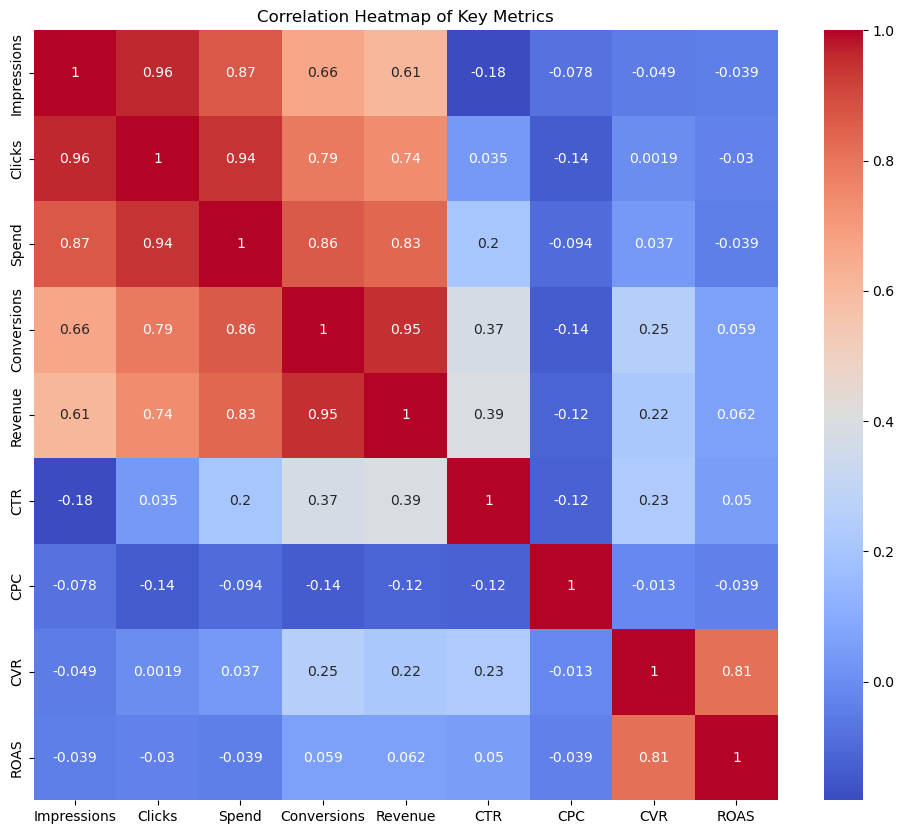

Top lagged correlations with Revenue:
Revenue          1.000000
Spend_lag_30     0.332852
Clicks_lag_30    0.264042
Clicks_lag_7    -0.199830
Spend_lag_7     -0.224374
Spend_lag_1     -0.296462
Clicks_lag_1    -0.316867
Name: Revenue, dtype: float64

7. Conversion Path Analysis
Conversion Path Analysis requires user-level data.
With such data, we could:
1. Identify the most common sequences of ad interactions before conversion
2. Calculate the average number of touchpoints before conversion
3. Determine which platforms are most effective at different stages of the customer journey

8. Anomaly Detection


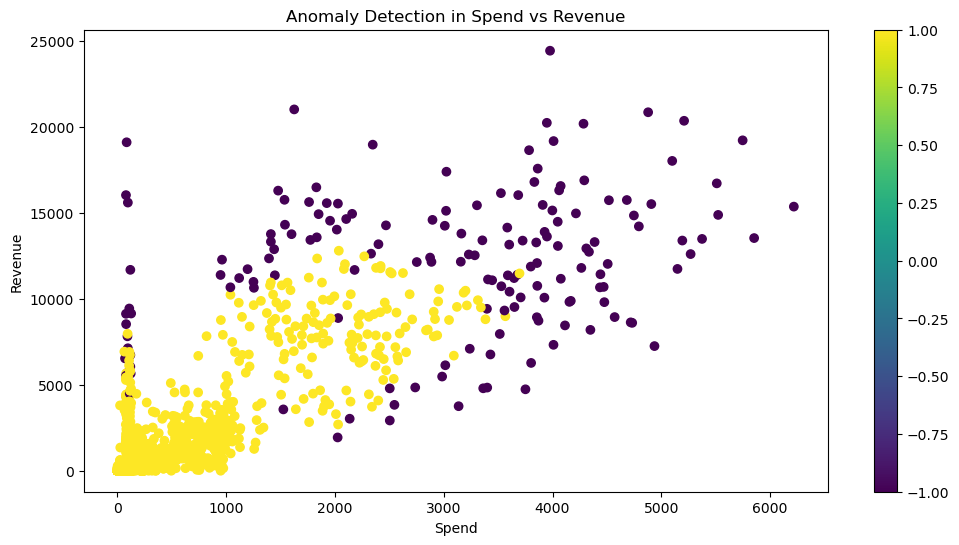

Top 10 anomalous days:
          Date      Source   Spend  Revenue
120 2024-01-31  Google Ads  6218.3  15357.7
147 2024-02-07  Google Ads  5853.3  13528.5
167 2024-02-12  Google Ads  5747.7  19212.0
139 2024-02-05  Google Ads  5522.6  14875.3
151 2024-02-08  Google Ads  5509.8  16710.0
116 2024-01-30  Google Ads  5374.6  13479.2
155 2024-02-09  Google Ads  5269.4  12598.0
96  2024-01-25  Google Ads  5209.3  20348.1
92  2024-01-24  Google Ads  5193.1  13384.7
112 2024-01-29  Google Ads  5148.5  11734.6


In [5]:
# Main execution
if __name__ == "__main__":
    print("1. High-Performing Campaign Analysis")
    top_campaigns = analyze_top_campaigns(data)
    
    print("\n2. Detailed Time Series Analysis")
    for metric in ['Spend', 'Conversions', 'Revenue']:
        print(f"\nTime Series Decomposition for {metric}")
        time_series_decomposition(data, metric)
    
    print("\n3. Platform Performance Comparison")
    compare_platforms(data)
    
    print("\n4. Efficiency Metric Deep Dive")
    analyze_efficiency_metrics(data)
    
    print("\n5. Budget Allocation Analysis")
    analyze_budget_allocation(data)
    
    print("\n6. Correlation Analysis")
    detailed_correlation_analysis(data)
    
    print("\n7. Conversion Path Analysis")
    analyze_conversion_path(data)
    
    print("\n8. Anomaly Detection")
    detect_anomalies(data)